# Project 4 Example
### Alec K. Mattu (UTA)
### INST 414
### 11/22/2021

# Instructions
**(1)** add your favorite song to the dataset as the last row. Manually enter the data entries of your favorite song (song name, artist name, year, and lyrics). 

**(2)**  Add a column  L which contains the number of words for each song, column V which contains the number of unique words for each song and column D containing the ratio V/L  (no scaling  needed).

**(3)** Vectorize songs using tfidf vectorization. So now for each song there is a tfidf vector. Store in a dataframe called tfidf_vecs. 

**(4)** Find the cosine similarity of your favorite song to every song in the dataset, using tfidf_vecs. 

**(5-1)** Now add a column to the data called class. We want to label the song classes based on the similarity to your favorite song. Find the median of all cosine similarities and if the similarity of a song is above the median level, label it 1 and if the similarity is less than median level, label it 0.

**(5-2)** Split the data to train and test set (0.25 of the rows in test set). Run simple logistic regression on this dataset, where features are year, L, V, and D and the output variable is class.

**(6)** Print the metrics to evaluate the performance of this classifier.

**(7)** Now select two of the features (out of 4 features) and repeat step 5 and 6. What do you observe? Do the metrics change if you select another two features? What does this change mean? Please add you answer in no more than 100 words, in a markdown cell.

**(8)** Plot the boundary decision for one of the selections in step 7 (your choice) and label the axes.

# Solution

## Part 0 - Preparation

In [1]:
# Import required libraries                               # HOMEWORK USAGE
import csv                                                # *Importing CSV
import pandas as pd                                       # General HW util
import sklearn.metrics as metrics                         # LogisticRegression Metrics
import sklearn.feature_extraction                         # Song Lengths (L, V)
import matplotlib.pyplot as plt                           # General Graphing Util
import requests                                           # *Collecting Favorite Song
from bs4 import BeautifulSoup as bs                       # *Collecting Favorite Song
from sklearn import linear_model                          # LogisticRegression
from sklearn.model_selection import train_test_split      # Splitting Training Data
from sklearn.metrics import classification_report         # LogisticRegression Classification
from mlxtend.plotting import plot_decision_regions        # Boundary Decision Graph

In [2]:
# Hold songs in a list
songs = []

# Open CSV file with handle
with open("dataset_out.csv") as csv_file:
    # Create a file reader
    file_reader = csv.DictReader(csv_file)
    
    # Loop through CSV rows
    for row in file_reader:
        songs.append(row)

## Part 1 - Favorite Song Information
Get the lyrics from azlyrics.com and then insert them into the CSV from Homework 1.

**OPTIONAL: Use the following approach instead of manually adding the song**

In [3]:
# Placeholder dict
song = {
    "Title": "taro",
    "Artist": "alt-j",
    "Year": 2012,
    "Lyrics": "",
}
page = requests.get("https://www.azlyrics.com/lyrics/altj/taro.html")

# Validate the lyric request
if (page.status_code != 200):
    print("Failed to download song lyrics")
    exit()

# Parse the HTML content from the request
soup = bs(page.content, "html.parser")
lyric_div = soup.find(class_= "col-xs-12 col-lg-8 text-center").find("div", attrs = {'class': None})   
lyrics = lyric_div.text.splitlines()
lyrics = list(filter(None, lyrics))

# Recombine the lyrics into a single string
song["Lyrics"] = str.join("\n", lyrics)
songs.append(song)

In [4]:
# Transform list into a DF
df = pd.DataFrame(songs)

In [5]:
# Drop the unnamed first column
df.drop(df.columns[0], axis = 1, inplace = True, errors = 'ignore')
df["Year"] = pd.to_numeric(df["Year"], errors = 'coerce')
df.dropna(axis = 0, inplace = True)

# Drop normalized columns
df.drop(["normalized_L", "normalized_V", "normalized_D"], axis = 1, inplace = True, errors = 'ignore')

# Drop Z-Score columns
df.drop(["z_score_L", "z_score_V", "z_score_D"], axis = 1, inplace = True, errors = 'ignore')

# Drop L, V, D
df.drop(["L", "V", "D"], axis = 1, inplace = True, errors = 'ignore')

In [6]:
df

,Title,Artist,Year,Lyrics
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a..."
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ..."
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ..."
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...
...,...,...,...,...
4495,the-dark-side-of-the-rainbow,da-grym-reefer,2012.0,Da Grym Reefer:\nI be sitting back\nThinking o...
4496,tester,anthrax,2006.0,"I've changed, by staying the same\nWhat does i..."
4497,killing-me-inside,crossfade,2011.0,There's a dream that comes to me\nAnd it whisp...
4498,babel,cruel-tie,2015.0,"I'm stepping down, hurrin' up. Settle down. Do..."


## Part 2 - Columns L, V, D
Get the lyrics from azlyrics.com and then insert them into the CSV from Homework 1.

**OPTIONAL: Use the following approach instead of manually adding the song**

In [7]:
# (A) Generate the unique number of words for each song
# Instantiate the bag of words (Count Vectorizer)
bower = sklearn.feature_extraction.text.CountVectorizer(
    lowercase  = True,
    stop_words = "english"
)

# Form a matrix with Sklearn
matrix = bower.fit_transform(df["Lyrics"])
matrix_df = pd.DataFrame(matrix.toarray())

# Turn the matrix into a series (single column)
length_series = matrix_df.sum(axis = 1, skipna = True)

# Merge the new series into the existing DataFrame
df.drop('L', axis = 1, inplace = True, errors = 'ignore')
df = pd.merge(df, length_series.rename('L'), left_index = True, right_index = True)
df.head()

,Title,Artist,Year,Lyrics,L
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...,103
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a...",98
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ...",197
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ...",43
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...,29


In [8]:
# (B) Count only the unique values
# Instantiate the bag of words (Count Vectorizer)
bower = sklearn.feature_extraction.text.CountVectorizer(
    lowercase  = True,
    stop_words = "english"
)

# Form a matrix with Sklearn
matrix = bower.fit_transform(df["Lyrics"])
matrix_df = pd.DataFrame(matrix.toarray())

# Find word counts greater than 0
unique_words_series = matrix_df > 0

# Sum the NUMBER of columns with words occuring 1 or more times
unique_words_series = unique_words_series.sum(axis = 1, skipna = True)
unique_word_df = unique_words_series.to_frame();
unique_word_df.columns = ["V"]

# Merge the new series into the existing DataFrame
df.drop('V', axis = 1, inplace = True, errors = 'ignore')
df = pd.merge(df, unique_word_df, left_index = True, right_index = True)
df.head()

,Title,Artist,Year,Lyrics,L,V
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...,103,70
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a...",98,41
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ...",197,74
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ...",43,38
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...,29,19


In [9]:
# (C) Ratio of Unique-to-Total columns (V/L)
# Simply divide V (unique length) by L (total length)
df["D"] = df["V"] / df["L"] 
df.tail()

,Title,Artist,Year,Lyrics,L,V,D
4395,el-cuarto-de-tula,buena-vista-social-club,2008.0,En el barrio La Cachimba se ha formado la corr...,98,41,0.418367
4396,hallelujah-i-love-her-so,gerry-and-the-pacemakers,2014.0,Let me tell you 'bout a boy (girl) I know.\nHe...,39,22,0.564103
4397,human-inventions,atrox,2007.0,So you took him moonward from the cellar. Put ...,95,51,0.536842
4398,die-nacht-des-unwesens,agathodaimon,2006.0,"Ach, Nacht, wie lieb du mir wrest\nWenn du die...",200,100,0.500000
4399,beautiful-noise,diplomats,2003.0,"[Jim Jones]\nMy homey Cash, well he gone for f...",130,98,0.753846


## Part 3 - Perform TF-IDF Vectorization

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize lyrics with TF-IDF
bag_of_words = TfidfVectorizer(tokenizer = lambda txt: txt.split())
docterm = bag_of_words.fit_transform(df["Lyrics"])

# Add document terms to a DataFrame
tfidf_vecs = pd.DataFrame(docterm.toarray(), columns = bag_of_words.get_feature_names(), index = df["Title"])

## Part 4 - Cosine Similarity

In [11]:
# Reference "Favorite Song" Row
ref = tfidf_vecs.iloc[-1]

# Pull cosine similarities to ref song
cosines = pd.DataFrame(tfidf_vecs.dot(ref), index = df["Title"])
cosines.columns = ["CS"]

In [12]:
cosines

,CS
Title,
the-battle,0.150060
hey-jude,0.110253
time,0.016685
we-can-make-the-world-a-whole-lot-brighter,0.120667
day-by-day,0.099048
...,...
el-cuarto-de-tula,0.003077
hallelujah-i-love-her-so,0.121995
human-inventions,0.090194


## Part 5 - Class

In [13]:
# Medium cosine similarity
median = cosines["CS"].median() # Pandas.Series.median

median

0.12453996670036406

In [14]:
cosines.reset_index(drop=True, inplace = True) # Fix Indexing Error

# Merge DF + Cosine DF
df.drop('CS', axis = 1, inplace = True, errors = 'ignore')
df = pd.concat([df, cosines], axis = 1)

In [15]:
df

,Title,Artist,Year,Lyrics,L,V,D,CS
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...,103.0,70.0,0.679612,0.150060
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a...",98.0,41.0,0.418367,0.110253
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ...",197.0,74.0,0.375635,0.016685
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ...",43.0,38.0,0.883721,0.120667
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...,29.0,19.0,0.655172,0.099048
...,...,...,...,...,...,...,...,...
4395,el-cuarto-de-tula,buena-vista-social-club,2008.0,En el barrio La Cachimba se ha formado la corr...,98.0,41.0,0.418367,NaN
4396,hallelujah-i-love-her-so,gerry-and-the-pacemakers,2014.0,Let me tell you 'bout a boy (girl) I know.\nHe...,39.0,22.0,0.564103,NaN
4397,human-inventions,atrox,2007.0,So you took him moonward from the cellar. Put ...,95.0,51.0,0.536842,NaN
4398,die-nacht-des-unwesens,agathodaimon,2006.0,"Ach, Nacht, wie lieb du mir wrest\nWenn du die...",200.0,100.0,0.500000,NaN


In [16]:
# Default class to 0
df["Class"] = 0

# Assign 1 values
df.loc[df.CS > median, ['Class']] = 1

In [17]:
df

,Title,Artist,Year,Lyrics,L,V,D,CS,Class
0,the-battle,blood-sweat-tears,1970.0,While the king and queen lie sleeping\nAnd the...,103.0,70.0,0.679612,0.150060,1
1,hey-jude,count-basie,1970.0,"Hey Jude, don't make it bad\nTake a sad song a...",98.0,41.0,0.418367,0.110253,0
2,time,david-bowie,1973.0,"Time, he's waiting in the wings\nHe speaks of ...",197.0,74.0,0.375635,0.016685,0
3,we-can-make-the-world-a-whole-lot-brighter,the-brady-bunch,1972.0,"Birds flying high,\nIn search of a clear blue ...",43.0,38.0,0.883721,0.120667,0
4,day-by-day,carmen-mcrae,1972.0,Day by day I'm falling more in love with you\n...,29.0,19.0,0.655172,0.099048,0
...,...,...,...,...,...,...,...,...,...
4395,el-cuarto-de-tula,buena-vista-social-club,2008.0,En el barrio La Cachimba se ha formado la corr...,98.0,41.0,0.418367,NaN,0
4396,hallelujah-i-love-her-so,gerry-and-the-pacemakers,2014.0,Let me tell you 'bout a boy (girl) I know.\nHe...,39.0,22.0,0.564103,NaN,0
4397,human-inventions,atrox,2007.0,So you took him moonward from the cellar. Put ...,95.0,51.0,0.536842,NaN,0
4398,die-nacht-des-unwesens,agathodaimon,2006.0,"Ach, Nacht, wie lieb du mir wrest\nWenn du die...",200.0,100.0,0.500000,NaN,0


## Step 6 - Logistic Regression

In [18]:
# Drop NA
df.dropna(inplace = True)

# Inputs
x = df[["Year", "L", "V", "D"]]

# Output
y = df["Class"]

# Split Data
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25)

In [19]:
# Setup Model
model = linear_model.LogisticRegression(max_iter = 1000)
model.fit(xtrain, ytrain)

# Determine Predictions
ypred = model.predict(xtest)
ypred_ps = model.predict_proba(xtest)

## Step 7 - Model Performance Metrics

In [20]:
print(model.score(xtest,ytest))
print(classification_report(ytest,ypred))

0.6223255813953489
              precision    recall  f1-score   support

           0       0.60      0.69      0.64       532
           1       0.65      0.55      0.60       543

    accuracy                           0.62      1075
   macro avg       0.63      0.62      0.62      1075
weighted avg       0.63      0.62      0.62      1075



## Step 8 - Logistic Regression with 2 Features

In [21]:
# Drop NA
df.dropna(inplace = True)

# Inputs
x = df[["L", "V"]]

# Output
y = df["Class"]

# Split Data
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25)

In [22]:
# Setup Model
model = linear_model.LogisticRegression(max_iter = 1000)
model.fit(xtrain, ytrain)

# Determine Predictions
ypred = model.predict(xtest)
ypred_ps = model.predict_proba(xtest)

In [23]:
print(model.score(xtest,ytest))
print(classification_report(ytest,ypred))

0.6213953488372093
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       535
           1       0.64      0.57      0.60       540

    accuracy                           0.62      1075
   macro avg       0.62      0.62      0.62      1075
weighted avg       0.62      0.62      0.62      1075



.

.

.

Short student answer covering: Do the metrics change between the two models, what does this change mean?

## Step 9 - Boundary Decision

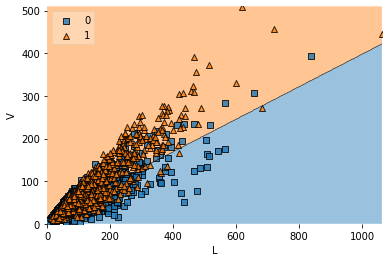

In [24]:
plot_decision_regions(x.values, y.values, clf = model, legend = 2)
plt.xlabel('L')
plt.ylabel('V')

# Hide Textual Output
None